# Wild deserts image classification
Training is done in [Google Colab](https://colab.research.google.com/drive/1SOflnQu87P5v9klSefdetHO2b85fqTIR?usp=sharing)

### Import libraries

In [6]:
from ultralytics import YOLO
import os
import pandas as pd
import time
from glob import glob
import re
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split
import shutil




#### Sort images into day/night

##### Testing

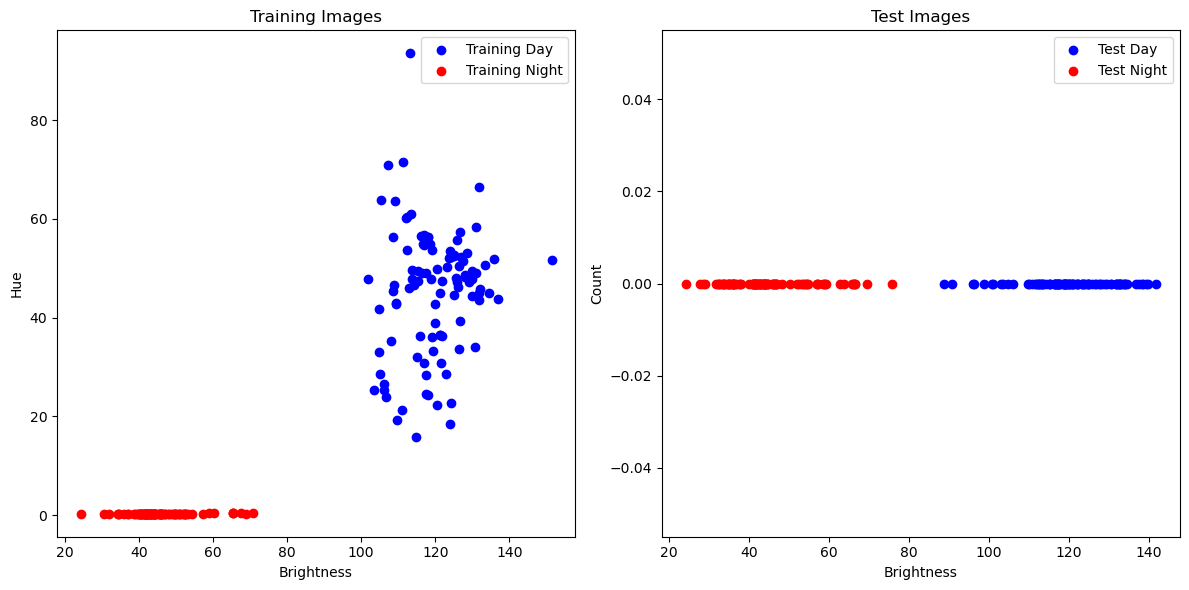

In [16]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the source directories for day and night images
image_dir_training_day = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\training\\day_night\\day\\train"
image_dir_test_day = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\training\\day_night\\day\\test"
image_dir_training_night = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\training\\day_night\\night\\train"
image_dir_test_night = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\training\\day_night\\night\\test"

def calculate_brightness_and_hue(image_path):
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    brightness = hsv_image[:, :, 2].mean()  # V channel represents brightness
    hue = hsv_image[:, :, 0].mean()  # H channel represents hue
    return brightness, hue

def get_brightness_and_hue(directory):
    brightness_values = []
    hue_values = []
    for filename in os.listdir(directory):
        if filename.endswith(".JPG") or filename.endswith(".jpg"):
            image_path = os.path.join(directory, filename)
            brightness, hue = calculate_brightness_and_hue(image_path)
            brightness_values.append(brightness)
            hue_values.append(hue)
    return brightness_values, hue_values

# Get brightness and hue values for each directory
training_day_brightness, training_day_hue = get_brightness_and_hue(image_dir_training_day)
training_night_brightness, training_night_hue = get_brightness_and_hue(image_dir_training_night)
test_day_brightness, test_day_hue = get_brightness_and_hue(image_dir_test_day)
test_night_brightness, test_night_hue = get_brightness_and_hue(image_dir_test_night)

# Plot the brightness and hue values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(training_day_brightness, training_day_hue, color='blue', label='Training Day')
plt.scatter(training_night_brightness, training_night_hue, color='red', label='Training Night')
plt.xlabel('Brightness')
plt.ylabel('Hue')
plt.title('Training Images')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(test_day_brightness, [0]*len(test_day_brightness), color='blue', label='Test Day')
plt.scatter(test_night_brightness, [0]*len(test_night_brightness), color='red', label='Test Night')
plt.xlabel('Brightness')
plt.ylabel('Count')
plt.title('Test Images')
plt.legend()

plt.tight_layout()
plt.show()

##### Actual classification of datasets

In [ ]:
import os
import shutil
import cv2

# Define the source directory and the target directories for day and night images
image_source_directory = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\training\\model_training_no_split\\14_classes_b_plus_empty\\images"
label_source_directory = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\training\\model_training_no_split\\14_classes_b_plus_empty\\labels"

day_directory_images = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\training\\model_training_day\\images"
day_directory_labels = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\training\\model_training_day\\labels"

night_directory_images = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\training\\model_training_night\\images"
night_directory_labels = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\training\\model_training_night\\labels"

# Create the target directories if they do not exist
os.makedirs(day_directory_images, exist_ok=True)
os.makedirs(day_directory_labels, exist_ok=True)
os.makedirs(night_directory_images, exist_ok=True)
os.makedirs(night_directory_labels, exist_ok=True)

def classify_image(image_path):
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    brightness = hsv_image[:, :, 2].mean()  # V channel represents brightness
    hue = hsv_image[:, :, 0].mean()  # H channel represents hue
    # Adjust the thresholds as needed
    if hue > 10:
        return 'day'
    else:
        return 'night'

# Classify and copy images and labels
for filename in os.listdir(image_source_directory):
    if filename.endswith(".JPG") or filename.endswith(".jpg"):
        image_path = os.path.join(image_source_directory, filename)
        label_path = os.path.join(label_source_directory, filename.replace(".JPG", ".txt").replace(".jpg", ".txt"))
        classification = classify_image(image_path)
        if classification == 'day':
            shutil.copy(image_path, os.path.join(day_directory_images, filename))
            shutil.copy(label_path, os.path.join(day_directory_labels, os.path.basename(label_path)))
        else:
            shutil.copy(image_path, os.path.join(night_directory_images, filename))
            shutil.copy(label_path, os.path.join(night_directory_labels, os.path.basename(label_path)))

print("Classification and copying completed!")

In [ ]:
help(os.makedirs)

### Reclassify labels
- This uses some basic text editing to replace values that are being reclassified
- Faster than reclassifying using [LabelStudio](https://labelstud.io/)
    - Can use LabelStudio if needed. Install using Docker is easiest
- I also split images into new test/train/val sets after reclassifying.
    - I use iterative_train_test_split from Scikit-multilearn to perform stratified classification
        - Need to stratify because of the imbalanced dataset


#### Reclassify images

In [ ]:
for file_path in glob('C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\training\\model_training_day\\labels\\*.txt'):
    print(f'{file_path}')
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        modified_lines = []
        for line in lines:
            to_remove = re.match(r'^(0 .*\n|3 .*\n|4 .*\n|7 .*\n|9 .*\n|10 .*\n|13 .*\n|15 .*\n|6 .*\n)', line)
            kangaroo = re.match(r'^(14 |12 |8 |5 )', line)
            rabbit = re.match(r'^(11 )', line)
            dingo = re.match(r'^(2 )', line)
            if to_remove:
                continue  # Skip appending this line
            elif kangaroo:
                modified_line = re.sub(r'^(14 |12 |8 |5 )', '0 ', line)
            elif rabbit:
                modified_line = re.sub(r'^(11 )', "2 ", line)
            elif dingo:
                modified_line = re.sub(r'^(2 )', "3 ", line)    
            else:
                modified_line = line  
            
            modified_lines.append(modified_line)
    with open(file_path, 'w', encoding='utf-8') as file:
        file.writelines(modified_lines)
        print(f'File written to: {file_path}')

print("Done!")

#### Split the reclassified images

This block actually just extracts the data from the YOLO labels and puts it into two numpy arrays

In [ ]:

# Path to your YOLO .txt annotations
annotations_path = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\training\\model_training_day\\labels\\*.txt"

# List all .txt files
txt_files = glob(annotations_path)

X = []  # Will store image paths or anything representing the "features"
y = []  # Will store the multi-label vectors of shape (16,)

for txt_file in txt_files:
    # Construct the corresponding image path
    # (assuming .jpg files, adjust if your images are .png, etc.)
    img_file = txt_file.replace(".txt", ".JPG")
    img_file = img_file.replace("labels", "images")
    # Initialize a 4-dimensional zero vector for the labels !!! MAKE SURE TO CHANGE IF YOU HAVE MORE CLASSES !!!
    labels = np.zeros(4, dtype=int)
    print(txt_file)
    # Read the YOLO annotation file
    with open(txt_file, "r") as f:
        for line in f:
            items = line.strip().split()
            if len(items) >= 5:
                class_id = int(items[0])
                # Mark that class_id as present
                labels[class_id] = 1

    # Append to X and y
    X.append(img_file)     # or store actual image data if needed
    y.append(labels)

X = np.array(X)
X = X.reshape(-1, 1)
y = np.array(y)


This block is the actual splitting

In [ ]:

test_size = 0.1 #10% of the data will be used for test

# Perform the iterative train/test split
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=test_size)
X_test = X_test.ravel()  
X_train = X_train.ravel()
print("After first split:")
print("  train:", X_train.shape, y_train.shape)

print("  test:     ", X_test.shape,    y_test.shape)

Validate image split

In [ ]:
import numpy as np

def count_classes(y_data):
    """ Sum over axis=0 to get how many samples contain each class. """
    return y_data.sum(axis=0)

def print_class_stats(name, y_data):
    counts = count_classes(y_data)
    print(f"{name} - counts per class: {counts}")
    print(f"{name} - total samples: {len(y_data)}\n")

print_class_stats("TRAIN", y_train)
print_class_stats("TEST",  y_test)



Move the files into their actual folders

In [ ]:
import shutil
from tqdm import tqdm
#Change these to your directories
labels_dir = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\training\\model_training_day\\labels"
images_dir = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\training\\model_training_day\\images"
# Create "labels" and "images" folders in each directory
for directory in [labels_dir, images_dir]:
    os.makedirs(os.path.join(directory, "test"), exist_ok=True)
    os.makedirs(os.path.join(directory, "train"), exist_ok=True)
    #os.makedirs(os.path.join(directory, "val"), exist_ok=True)
# Copy test images and labels. Note that this leaves the files in the original directories too
for img_path in tqdm(X_test, desc="Copying test data"):
    
    txt_path = img_path.replace(".JPG", ".txt")
    txt_path = txt_path.replace("images", "labels")

    shutil.copy(img_path, os.path.join(images_dir, "test"))
    shutil.copy(txt_path, os.path.join(labels_dir, "test"))
# Copy training images and labels
for img_path in tqdm(X_train, desc="Copying training data"):
    txt_path = img_path.replace(".JPG", ".txt")  # or .png, whichever you have
    txt_path = txt_path.replace("images", "labels")
    shutil.copy(img_path, os.path.join(images_dir, "train"))
    shutil.copy(txt_path, os.path.join(labels_dir, "train"))

# Copy validation images and labels
'''for img_path in tqdm(X_val, desc="Copying validation data"):
    txt_path = img_path.replace(".JPG", ".txt")  # or .png, whichever you have
    txt_path = txt_path.replace("images", "labels")

    shutil.copy(img_path, os.path.join(images_dir, "val"))
    shutil.copy(txt_path, os.path.join(labels_dir, "val"))'''




### Set variables/filepaths 

In [ ]:
validation_root_directory = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\validation"
model = YOLO("C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\training_output\\model_training_night\\output\\content\\runs\\detect\\train2\\weights\\best.pt")

### Trained model validation/prediction
The model needs to be trained on Colab prior to this step

##### This block is an old training workflow but I have kept it here for reference

In [ ]:
import shutil
all_detections = []
for folder in os.listdir(f"{validation_root_directory}/all_images/"):
    print(folder)
    directory = f"{validation_root_directory}/all_images/{folder}/"
    
    for counter, image in enumerate(os.listdir(directory), start=1):
        name, ext = os.path.splitext(image)
        print(f"{counter}/{len(os.listdir(directory))}")
        
        if ext == '.JPG':  
            
            predictions = model.predict(
                source=os.path.join(directory, image),
                save=True,
                save_txt=True,
                save_conf=False,
                imgsz=640,
                conf=0.1,
                iou=0.5,
                augment=True,
                project=f"{validation_root_directory}/output3/labels_images/predict",
                name = "test"
            )
            os.makedirs(f"{validation_root_directory}/output3/labels_images/predict/images", exist_ok=True)
            shutil.copy(os.path.join(directory, image), f"{validation_root_directory}/output3/labels_images/predict/images/{name}.jpg")
            if predictions[0]:
                species = model.names[int(predictions[0].boxes.cls[0])]
                conf = round(float(predictions[0].boxes.conf[0]), 3)
                path = predictions[0].path
                print(path)
                bbox = predictions[0].boxes.xywh.tolist()
                df = pd.DataFrame({'path': path, 'species': species, 'confidence': conf, 'bbox': bbox, })
                all_detections.append(df)
                newpath = f"{validation_root_directory}/output3/{species}"
            else:
                print("No detections were made.")
                newpath = f"{validation_root_directory}/output3/empty"
            
            os.makedirs(newpath, exist_ok=True)
            predictions[0].save(f"{newpath}/{name}_{conf if predictions[0] else ''}.jpg")
            
            os.makedirs(all_images_path, exist_ok=True)
            predictions[0].save(f"{all_images_path}/{name}_{conf if predictions[0] else ''}_{species if predictions[0] else 'empty'}.jpg")

timestamp = time.strftime("%Y%m%d_%H%M%S")
if all_detections:
    final_df = pd.concat(all_detections)
    final_df.to_csv(f"{validation_root_directory}/output3/detections_{timestamp}.csv", index=False)
else:
    print("No detections were made.")


##### New training block

Need to split into day/night images for the day/night models

In [26]:
import os
import shutil
import cv2

# Define the source directory and the target directories for day and night images
image_source_directory = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\validation\\all_images_no_folders"

day_directory_images = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\validation\\all_images_day_night\\day"

night_directory_images = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\validation\\all_images_day_night\\night"

# Create the target directories if they do not exist
os.makedirs(day_directory_images, exist_ok=True)
os.makedirs(night_directory_images, exist_ok=True)

def classify_image(image_path):
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    brightness = hsv_image[:, :, 2].mean()  # V channel represents brightness
    hue = hsv_image[:, :, 0].mean()  # H channel represents hue
    # Adjust the thresholds as needed
    if hue > 10:
        return 'day'
    else:
        return 'night'

# Classify and copy images
for filename in os.listdir(image_source_directory):
    if filename.endswith(".JPG") or filename.endswith(".jpg"):
        image_path = os.path.join(image_source_directory, filename)
        print(image_path)
        classification = classify_image(image_path)
        if classification == 'day':
            shutil.copy(image_path, os.path.join(day_directory_images, filename))
        else:
            shutil.copy(image_path, os.path.join(night_directory_images, filename))

print("Classification and copying completed!")

C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Image classification\validation\all_images_no_folders\2017-11-08 12-23-25 M 2_3.JPG
C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Image classification\validation\all_images_no_folders\2017-11-08 13-06-05 M 3_3.JPG
C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Image classification\validation\all_images_no_folders\2017-11-08 21-50-40 M 1_3.JPG
C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Image classification\validation\all_images_no_folders\2017-11-08 22-09-12 M 1_3.JPG
C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Image classification\validation\all_images_no_folders\2017-11-08 23-09-43 M 2_3.JPG
C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Image classification\validation\all_images_no_folders\2017-11-08 23-50-18 M 1_3.JPG
C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Image classification\validation\all_images_no_folders\2

In [25]:
image_path = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\validation\\all_images_day_night\\night\\2018-11-21 18-17-24 M 1_3.JPG"
brightness, hue = calculate_brightness_and_hue(image_path)
print(f"Hue: {hue}")
print(f"Brightness: {brightness}")

Hue: 19.80094943576389
Brightness: 115.56166517469617


In [ ]:
directory = f"{validation_root_directory}\\all_images_day_night\\night"


predictions = model.predict(
    source=os.path.join(directory),
    save=False, # I don't save anything here because I want to sort into folders
    save_txt=False,
    save_conf=False,
    imgsz=640,
    conf=0.1,
    iou=0.5,
    show=False)



This block is if you want to do validation in digikam or R later

In [ ]:
all_detections = []

for i in range(len(all_predictions)):
    #if detections
    if all_predictions[i].boxes:  # Check if there are any boxes in the prediction
        species = model.names[int(all_predictions[i].boxes.cls[0])]
        conf = round(float(all_predictions[i].boxes.conf[0]), 3)
        path = all_predictions[i].path
        # Use the correct index i instead of 1
        name = os.path.splitext(os.path.basename(all_predictions[i].path))[0]
        bbox = all_predictions[i].boxes.xywh.tolist()
        # 5) Save the label file in the "labels" folder
        labels_dir = f"{validation_root_directory}/output3/labels_images/predict/labels"
        os.makedirs(labels_dir, exist_ok=True)
        labels_path = f"{labels_dir}/{name}.txt"
        all_predictions[i].save_txt(labels_path)
    #if no detections
    else:
        species = "none"
        conf = "none"
        path = all_predictions[i].path
        name = os.path.splitext(os.path.basename(all_predictions[i].path))[0]
        bbox = "none"
        labels_dir = f"{validation_root_directory}/output3/labels_images/predict/labels"
        os.makedirs(labels_dir, exist_ok=True)
        labels_path = f"{labels_dir}/{name}.txt"
        with open(labels_path, 'w') as f:
            f.write('')
        print(f"No detections for prediction {i}")
        
    # 1) Create a folder for this species
    newpath = f"{validation_root_directory}/output3/{species}"
    os.makedirs(newpath, exist_ok=True)

    # 2) Save the annotated image to the species folder
    all_predictions[i].save(f"{newpath}/{name}.jpg")

    # 3) Save the original image in the "images" folder
    images_dir = f"{validation_root_directory}/output3/labels_images/predict/images"
    os.makedirs(images_dir, exist_ok=True)
    shutil.copy(path, images_dir)
    path_original = f"{images_dir}/{name}.JPG"

    # 4) Save the annotated image in the "annotated" folder
    annotated_dir = f"{validation_root_directory}/output3/labels_images/predict/annotated"
    os.makedirs(annotated_dir, exist_ok=True)
    path_annotated = f"{annotated_dir}/{name}.JPG"
    all_predictions[i].save(path_annotated)



    # 5) Build a DataFrame row (no classification check here)
    df = pd.DataFrame({
        'path_original': [path_original],
        'species': [species],
        'confidence': [conf],
        'bbox': [bbox],
        'path_annotated': [path_annotated],
        'label_path': [labels_path]
    })

    # 6) Append this to all_detections
    all_detections.append(df)
    


# Finally, save all detections to a CSV
timestamp = time.strftime("%Y%m%d_%H%M%S")
if all_detections:
    final_df = pd.concat(all_detections, ignore_index=True)
    final_df.to_csv(f"{validation_root_directory}/output3/detections_{timestamp}.csv", index=False)


In [ ]:
import cv2
import matplotlib.pyplot as plt

for i in range(len(all_predictions)):
    if all_predictions[i].boxes:  # Check if there are any boxes in the prediction
        species = model.names[int(all_predictions[i].boxes.cls[0])]
        conf = round(float(all_predictions[i].boxes.conf[0]), 3)
        path = all_predictions[i].path
        name = os.path.splitext(os.path.basename(all_predictions[i].path))[0]
        bbox = all_predictions[i].boxes.xywh.tolist()
        # save the label file to the labels folder
        labels_path = f"{validation_root_directory}/output3/labels_images/predict/labels/{name}.txt"
        all_predictions[i].save_txt(labels_path)

    else:
        species = "none"
        conf = "none"
        path = all_predictions[i].path
        name = os.path.splitext(os.path.basename(all_predictions[i].path))[0]
        bbox = "none"
        labels_dir = f"{validation_root_directory}/output3/labels_images/predict/labels"
        os.makedirs(labels_dir, exist_ok=True)
        labels_path = f"{labels_dir}/{name}.txt"
        with open(labels_path, 'w') as f:
            f.write('')
        print(f"No detections for prediction {i}")
    
    # save the annotated image to the species folder
    newpath = f"{validation_root_directory}/output3/{species}"  
    os.makedirs(newpath, exist_ok=True)
    all_predictions[i].save(f"{newpath}/{name}.jpg")
        
    # save the original image to the images folder
    os.makedirs(f"{validation_root_directory}/output3/labels_images/predict/images", exist_ok=True)
    shutil.copy(path, f"{validation_root_directory}/output3/labels_images/predict/images")
    path_original = f"{validation_root_directory}/output3/labels_images/predict/images/{name}.JPG"
        
    # save the annotated image to the annotated folder
    path_annotated = f"{validation_root_directory}/output3/labels_images/predict/annotated/{name}.JPG"
    os.makedirs(f"{validation_root_directory}/output3/labels_images/predict/annotated", exist_ok=True)
    all_predictions[i].save(f"{validation_root_directory}/output3/labels_images/predict/annotated/{name}.JPG")
        
    
        
    # Display the annotated image in a pop-up window with smaller size
    img = cv2.imread(path_annotated)
    img_resized = cv2.resize(img, (800, 600))  # Resize the image to 800x600
    cv2.imshow(f"Species: {species}, Confidence: {conf}", img_resized)

    cv2.moveWindow(f"Species: {species}, Confidence: {conf}", 0, 0)  # Move the window to the top left corner
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    # Prompt user for input
    result = input("Is the detection correct? (y/n): ").strip().lower()
    
    # save the data to a dataframe
    df = pd.DataFrame({'path_original': [path_original], 
                        'species': [species], 
                        'confidence': [conf], 
                        'bbox': [bbox], 
                        "path_annotated": [path_annotated],
                        "label_path": [labels_path],
                        "results": [result]})
    
    # append the dataframe to the list of all detections
    all_detections.append(df)
    

# Save the results to a CSV file
timestamp = time.strftime("%Y%m%d_%H%M%S")
if all_detections:
    final_df = pd.concat(all_detections)
    final_df.to_csv(f"{validation_root_directory}/output3/detections_{timestamp}.csv", index=False)


In [ ]:
df

In [ ]:
predictions[1].path
name = os.path.splitext(os.path.basename(predictions[1].path))[0]
name


In [ ]:
predictions[0].